
<font size = "5"> **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Lattice Determination with HOLZ

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Diffraction/CH2_12-HOLZ_Example.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Diffraction/CH2_12-HOLZ_Example.ipynb)



part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>


**Spring 2024**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Khalid Hattar</td>
  </tr>
  <tr>
    <td>Microscopy Facilities</td> 
    <td> Tennessee Ion Beam Materials Laboratory </td>
  </tr>
  
  <tr>
    <td>Materials Science & Engineering</td>
    <td> Nuclear Engineering</td>
  </tr>
  <tr>
    <td>Institute of Advanced Materials & Manufacturing</td>
    <td> </td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
Background and methods to analysis and quantification of data acquired with transmission electron microscopes

## Load relevant python packages
### Check Installed Packages

In [4]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.1.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade

if 'google.colab' in sys.modules:
    !{sys.executable} -m pip install numpy==1.24.4
print('done')

done


## Import numerical and plotting python packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,

and some libraries from the book
* kinematic scattering library.
* file_tools library

In [1]:
%matplotlib  widget
import matplotlib.pyplot as plt
import numpy as np
import sys
if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()

# additional package 
import  itertools 
import scipy.constants as const

import ipywidgets as ipyw

# Import libraries from pyTEMlib
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book

### And we use the image tool library of Quantifit
import pyTEMlib.file_tools as ft
import pyTEMlib

__notebook_version__ = '2024.01.21'

print('pyTEM version: ', pyTEMlib.__version__)
print('notebook version: ', __notebook_version__)

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
Using kinematic_scattering library version {_version_ }  by G.Duscher
pyTEM version:  0.2024.09.0
notebook version:  2024.01.21



## Define  crystal


In [2]:
### Please choose another crystal like: Silicon, Aluminium, GaAs , ZnO
atoms = ks.structure_by_name('silicon')


# Plot the unit cell

<Axes: >

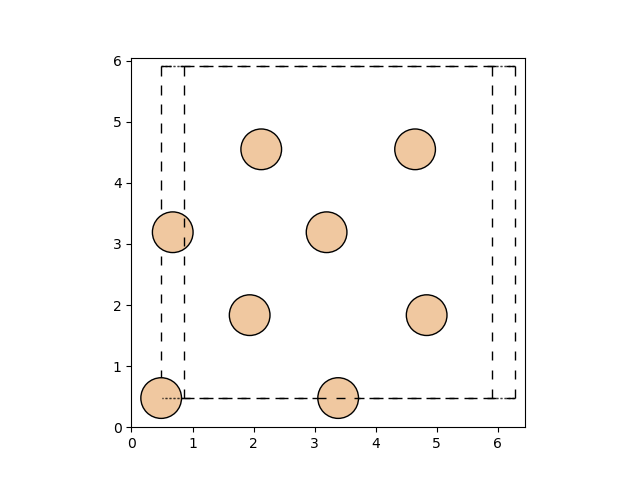

In [3]:
## Just to be sure the crystal structure is right
from ase.visualize.plot import plot_atoms

plot_atoms(atoms, radii=0.3, rotation=('0x,4y,0z'))

## Load Diffraction Pattern

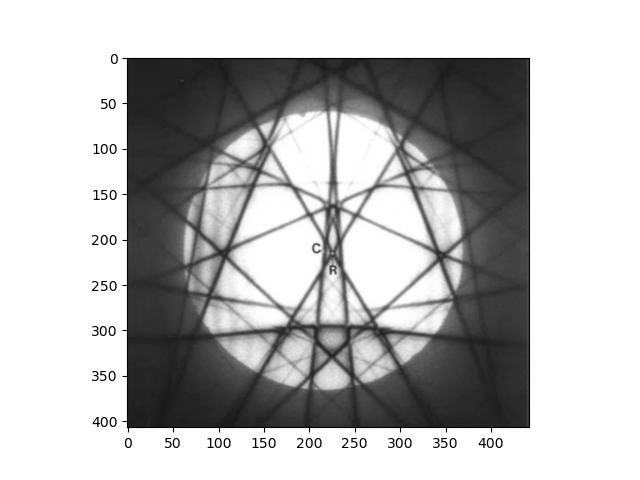

In [4]:
image = plt.imread("images/Zuo-HOLZ-experiment.jpg")
plt.figure()
plt.imshow(image);


# Parameters for Diffraction Calculation

Please note that we are using a rather small number of reflections: the maximum number of hkl is 1

In [6]:
tags = {}
tags['acceleration_voltage_V'] = 98.8*1000.0 #V

tags['zone_hkl'] = np.array([-2,2,1])  # incident neares zone axis: defines Laue Zones!!!!
tags['mistilt']  = np.array([-0.0,-0.0,-0.0])  # mistilt in degrees

tags['Sg_max'] = .2 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = 9   # Highest evaluated Miller indices
tags['convergence_angle_nm'] = 1.9
atoms.info['experimental'] = tags

## Function for Coverting Hough Coordinates to Line Coordinates

In [7]:

def Hough2Lines(tags):
    angle = np.radians(tags['plot_rotation']) #mrad
    # Calculate nearest point of HOLZ and Kikuchi lines
    
    L = tags['convergence_angle_A-1']*2
    if L < 0.1:
        L=3
    theta = tags['HOLZ']['theta']-angle
    gd_length = tags['HOLZ']['distance'] 
    
    g_closest = np.ones((len(theta),2))
    g_closest[:,1] = np.cos(theta)
    g_closest[:,0] = np.sin(theta)
    
    g_closest =  g_closest*(gd_length/np.linalg.norm(g_closest, axis =1))[:,np.newaxis]
    
    g_line = np.zeros(g_closest.shape)
    g_line[:,0] = np.cos(np.pi-theta)
    g_line[:,1] = np.sin(np.pi-theta)
    

    line_start = g_closest+g_line*L
    line_end = g_closest-g_line*L
    lines = np.zeros((g_line.shape[0],5))
    lines[:,0] = line_start[:,0]
    lines[:,1] = line_end[:,0]
    lines[:,2] = line_start[:,1]
    lines[:,3] = line_end[:,1]
    lines[:,4] = tags['HOLZ']['intensities']#tags['allowed']['intensities']
    
    lines[tags['allowed']['ZOLZ'],4] = tags['allowed']['intensities'][tags['allowed']['ZOLZ']]/tags['allowed']['intensities'].max()*4
    return lines, g_closest


## Initial Overlay

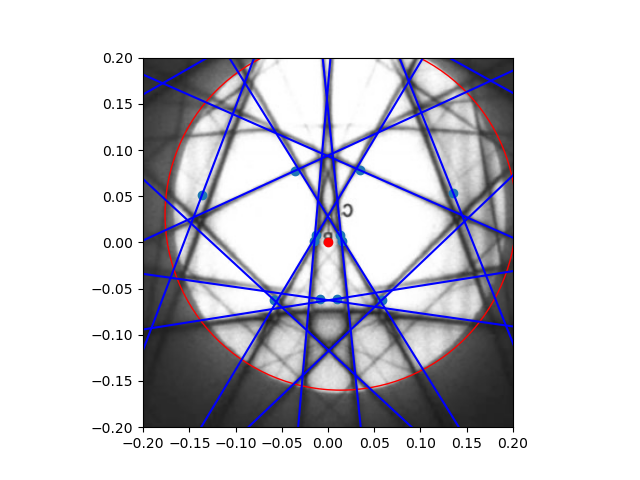

In [8]:
atoms.info['experimental']['acceleration_voltage_V'] = 99.2*1000.0 #V

tags['zone_hkl'] = np.array([-2,2,1])  # incident neares zone axis: defines Laue Zones!!!!
tags['mistilt']  = np.array([-0.0,-0.0,-0.0])  # mistilt in degrees

tags['Sg_max'] = .04 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = 9   # Highest evaluated Miller indices
tags['convergence_angle_A-1'] = 1.9
atoms.info['experimental'] = tags

ks.kinematic_scattering(atoms, False)

tagsD = atoms.info['diffraction']
tagsD['convergence_angle_A-1'] = .19
tagsD['plot_rotation'] = 162
tagsD['plot image FOV'] = .516
tagsD['plot shift x'] = 0.0065
tagsD['plot shift y'] = .043

lines, g_closest = Hough2Lines(tagsD)

# we sort them by order of Laue zone
ZOLZ = tagsD['allowed']['ZOLZ']
HOLZ = tagsD['allowed']['HOLZ']

l = -tagsD['plot image FOV']/2+tagsD['plot shift x']
r = tagsD['plot image FOV']/2+tagsD['plot shift x']
t = -tagsD['plot image FOV']/2+tagsD['plot shift y']
b = tagsD['plot image FOV']/2+tagsD['plot shift y']

plt.figure()#
plt.imshow(image, extent=(r,l,t,b))
plt.scatter(g_closest[:,0],g_closest[:,1])
#plt.scatter(line_start[:,0],line_start[:,1],c='g')
#plt.scatter(line_end[:,0],line_end[:,1],c='g')
plt.plot((lines[HOLZ,0],lines[HOLZ,1]),(lines[HOLZ,2],lines[HOLZ,3]),c='b')
plt.plot((lines[ZOLZ,0],lines[ZOLZ,1]),(lines[ZOLZ,2],lines[ZOLZ,3]),c='c')
zero_disk = plt.Circle((tagsD['plot shift x']*2.1, tagsD['plot shift y']*0.7), tagsD['convergence_angle_A-1'],
                       color='r', fill=False)
plt.scatter([0],[0],c='red')
plt.gca().add_artist(zero_disk)
s = 0.2
plt.gca().set_xlim(-s,s)
plt.gca().set_ylim(-s,s)
plt.show()

## Plotting with mistilt included and objective stigmation compensated

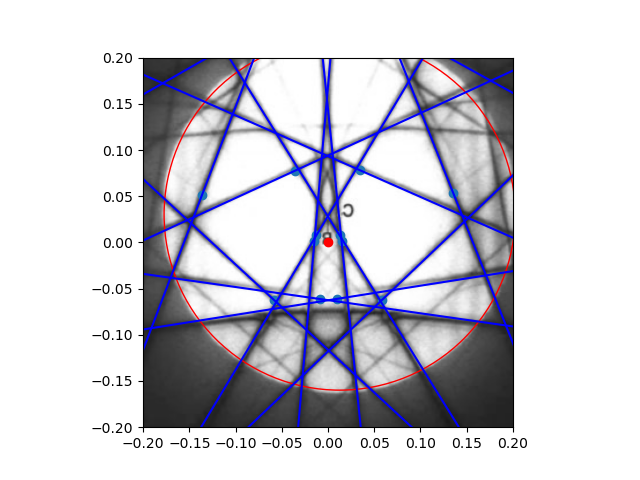

In [9]:
# -----Input----
O_stig = 1.07
# --------------

atoms.info['experimental']['acceleration_voltage_V'] = 99.2*1000.0 #V

tags['zone_hkl'] = np.array([-2,2,1])  # incident neares zone axis: defines Laue Zones!!!!
tags['mistilt']  = np.array([-0.05,-0.05,-0.03])  # mistilt in degrees

tags['Sg_max'] = .02 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = 9   # Highest evaluated Miller indices
tags['unit_cell'][0,0]=tags['unit_cell'][1,1]*1.00
tags['unit_cell'][2,2]=tags['unit_cell'][1,1]*1.00
tags['unit_cell'][2,1] = .00
tags['unit_cell'] = tags['unit_cell']*1.00

tags['convergence_angle_A-1'] = 1.9
atoms.info['experimental'] = tags

ks.kinematic_scattering(atoms, False)

tagsD = atoms.info['diffraction']
tagsD['convergence_angle_A-1'] = .19
tagsD['plot_rotation'] = 162
tagsD['plot image FOV'] = .516
tagsD['plot shift x'] = 0.006
tagsD['plot shift y'] = .043

lines, g_closest = Hough2Lines(tagsD)

# we sort them by order of Laue zone
ZOLZ = tagsD['allowed']['ZOLZ']
HOLZ = tagsD['allowed']['HOLZ']

l = -tagsD['plot image FOV']/2*O_stig + tagsD['plot shift x']
r = tagsD['plot image FOV']/2*O_stig + tagsD['plot shift x']
t = -tagsD['plot image FOV']/2+tagsD['plot shift y']
b = tagsD['plot image FOV']/2+tagsD['plot shift y']

plt.figure()#
plt.imshow(image, extent=(r,l,t,b))
plt.scatter(g_closest[:,0],g_closest[:,1])
#plt.scatter(line_start[:,0],line_start[:,1],c='g')
#plt.scatter(line_end[:,0],line_end[:,1],c='g')
plt.plot((lines[HOLZ,0],lines[HOLZ,1]),(lines[HOLZ,2],lines[HOLZ,3]),c='b')
plt.plot((lines[ZOLZ,0],lines[ZOLZ,1]),(lines[ZOLZ,2],lines[ZOLZ,3]),c='c')
zero_disk = plt.Circle((tagsD['plot shift x']*2.1, tagsD['plot shift y']*0.7), tagsD['convergence_angle_A-1'],
                       color='r', fill=False)
plt.scatter([0],[0],c='red')
plt.gca().add_artist(zero_disk)
s = 0.2
plt.gca().set_xlim(-s,s)
plt.gca().set_ylim(-s,s);

## Plotting more HOLZ lines with intensity

In the image above, all major lines are reproduced.

On the bottom of the HOLZ plot, however, the faint lines are not there.

> Increase the maximum hkl in the simulation to see how well we did


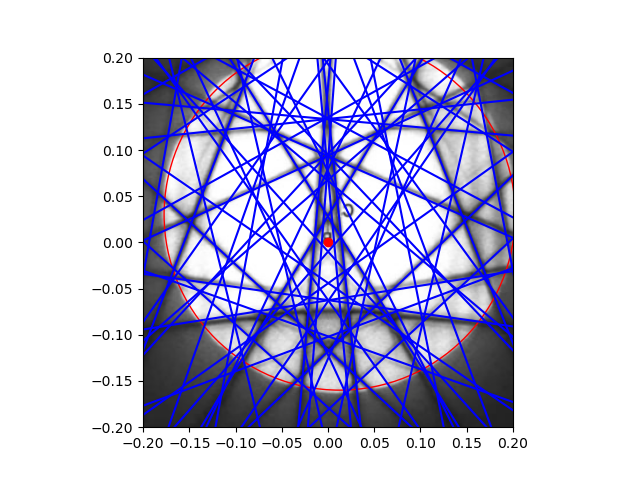

In [10]:
# -----Input----
Sg_max = .02 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
maximum_hkl = 16   # Highest evaluated Miller indices
# --------------

O_stig = 1.07

atoms.info['experimental']['acceleration_voltage_V'] = 99.2*1000.0 #V

tags['zone_hkl'] = np.array([-2,2,1])  # incident neares zone axis: defines Laue Zones!!!!
tags['mistilt']  = np.array([0,0,0]) #-0.05,-0.07,-0.03])  # mistilt in degrees

tags['Sg_max'] = Sg_max # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = maximum_hkl   # Highest evaluated Miller indices

tags['convergence_angle_A-1'] = 1.9
atoms.info['experimental'] = tags

ks.kinematic_scattering(atoms, False)

tagsD = atoms.info['diffraction']
tagsD['convergence_angle_A-1'] = .19
tagsD['plot_rotation'] = 162
tagsD['plot image FOV'] = .516
tagsD['plot shift x'] = 0.006
tagsD['plot shift y'] = .043

lines, g_closest = Hough2Lines(tagsD)

# we sort them by order of Laue zone
ZOLZ = tagsD['allowed']['ZOLZ']
HOLZ = tagsD['allowed']['HOLZ']

l = -tagsD['plot image FOV']/2*O_stig + tagsD['plot shift x']
r = tagsD['plot image FOV']/2*O_stig + tagsD['plot shift x']
t = -tagsD['plot image FOV']/2+tagsD['plot shift y']
b = tagsD['plot image FOV']/2+tagsD['plot shift y']

plt.figure()
plt.imshow(image, extent=(r,l,t,b))
plt.plot((lines[HOLZ,0],lines[HOLZ,1]),(lines[HOLZ,2],lines[HOLZ,3]),c='b')
plt.plot((lines[ZOLZ,0],lines[ZOLZ,1]),(lines[ZOLZ,2],lines[ZOLZ,3]),c='c')
zero_disk = plt.Circle((tagsD['plot shift x']*2.1, tagsD['plot shift y']*0.7), tagsD['convergence_angle_A-1'],
                       color='r', fill=False)
plt.scatter([0],[0],c='red')
plt.gca().add_artist(zero_disk)
s = 0.2
plt.gca().set_xlim(-s,s)
plt.gca().set_ylim(-s,s);


## Save unit cell data

In [11]:
unit_cell = tags['unit_cell'].copy()

## Influence of unit cell deformation
> Introduce a bit of distortion in the unit cell and see what happens

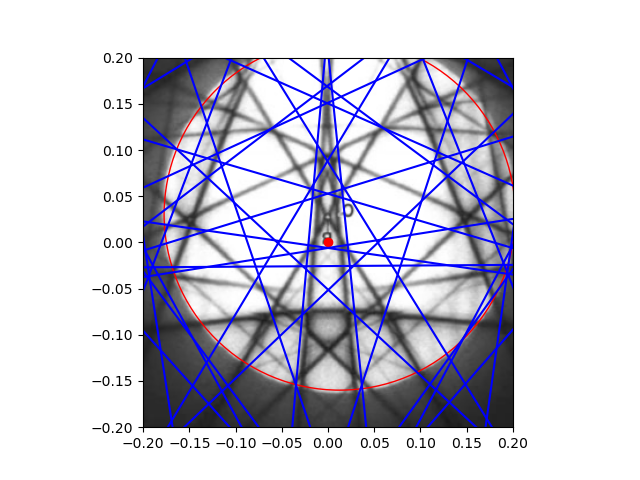

In [13]:
# -----Input----
tags['unit_cell'][0,0]=unit_cell[0,0]+0.00
tags['unit_cell'][2,2]=unit_cell[1,1]+0.02
tags['unit_cell'][2,1] = .00
tags['unit_cell'] = unit_cell*1.0
# --------------


Sg_max = .02 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
maximum_hkl = 9   # Highest evaluated Miller indices

O_stig = 1.07

atoms.info['experimental']['acceleration_voltage_V'] = 99.2*1000.0 #V

tags['zone_hkl'] = np.array([-2,2,1])  # incident neares zone axis: defines Laue Zones!!!!
tags['mistilt']  = np.array([0,0,0]) #-0.05,-0.07,-0.03])  # mistilt in degrees

tags['Sg_max'] = Sg_max # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = maximum_hkl   # Highest evaluated Miller indices

tags['convergence_angle_A-1'] = 1.9
atoms.info['experimental'] = tags

ks.kinematic_scattering(atoms, False)

tagsD = atoms.info['diffraction']
tagsD['convergence_angle_A-1'] = .19
tagsD['plot_rotation'] = 162
tagsD['plot image FOV'] = .516
tagsD['plot shift x'] = 0.006
tagsD['plot shift y'] = .043

lines, g_closest = Hough2Lines(tagsD)

# we sort them by order of Laue zone
ZOLZ = tagsD['allowed']['ZOLZ']
HOLZ = tagsD['allowed']['HOLZ']

l = -tagsD['plot image FOV']/2*O_stig + tagsD['plot shift x']
r = tagsD['plot image FOV']/2*O_stig + tagsD['plot shift x']
t = -tagsD['plot image FOV']/2+tagsD['plot shift y']
b = tagsD['plot image FOV']/2+tagsD['plot shift y']

plt.figure()
plt.imshow(image, extent=(r,l,t,b))
plt.plot((lines[HOLZ,0],lines[HOLZ,1]),(lines[HOLZ,2],lines[HOLZ,3]),c='b')
plt.plot((lines[ZOLZ,0],lines[ZOLZ,1]),(lines[ZOLZ,2],lines[ZOLZ,3]),c='c')
zero_disk = plt.Circle((tagsD['plot shift x']*2.1, tagsD['plot shift y']*0.7), tagsD['convergence_angle_A-1'],
                       color='r', fill=False)
plt.scatter([0],[0],c='red')
plt.gca().add_artist(zero_disk)
s = 0.2
plt.gca().set_xlim(-s,s)
plt.gca().set_ylim(-s,s);


## Conclusion
Due to the high angles involved in the scattering but measured at low angles, HOLZ lines provide a very sensitive measurement of experimental and materials parameter. 

## Navigation

- <font size = "3">  **Back: [HOLZ Lines](CH2_11-HOLZ_Lines.ipynb)** </font>
- <font size = "3">  **Next: [Dynamic Diffraction: Bloch Waves](CH2_D01-Bloch.ipynb)** </font>
- <font size = "3">  **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>
